# PyTorch Lightning

We want to use PyTorch Lightning  now.

In [1]:
import os
from pathlib import Path
from typing import Optional
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner

from torch.utils.data import random_split, DataLoader
from torchvision.datasets.utils import download_and_extract_archive

## Datamodule

In [2]:
class CatDogImageDataModule(pl.LightningDataModule):
    def __init__(self, dl_path='./tmp', batch_size = 32, num_workers=0, cache_dataset=True):
        super().__init__()
        self._dl_path = dl_path
        self.batch_size = batch_size
        self._num_workers = num_workers
        self._cache_dataset = cache_dataset

    @property
    def data_path(self):
        return Path(self._dl_path).joinpath("PetImages")

    @property
    def normalize_transform(self):
        return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    @property
    def train_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            self.normalize_transform,
        ])

    @property
    def val_transform(self):
        return transforms.Compose([
            transforms.Resize((224, 224)), 
            transforms.ToTensor(), 
            self.normalize_transform
        ])

    def prepare_data(self):
        """Download images and prepare images datasets."""
        url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'  
        if not os.path.exists(self.data_path):
            os.makedirs(self.data_path)
        if len(os.listdir(self.data_path)) == 0:
            download_and_extract_archive(url=url, download_root=self._dl_path, remove_finished=not self._cache_dataset)
        else:
            print("Dataset already exists, skipping download and extraction...")

    def setup(self, stage: Optional[str] = None):
        # make assignments here (val/train/test split)
        dataset = self.create_dataset(self.data_path, self.train_transform)
        self.train_data, self.val_data = random_split(dataset, [0.8, 0.2])

        print("Dataset created, split:")
        print(f'training images: {len(self.train_data)}')
        print(f'validation images: {len(self.val_data)}')
        #self.log.info("Dataset created, split:")
        #log.info(f'training images: {len(self.train_data)}')
        #log.info(f'validation images: {len(self.val_data)}')

    def create_dataset(self, root, transform):
        return ImageFolder(root=root, transform=transform, is_valid_file=self._is_image_valid)

    def train_dataloader(self):
        #self.log.info("Training data loaded.")
        return DataLoader(dataset=self.train_data, batch_size=self.batch_size, num_workers=self._num_workers, shuffle=True)
    
    def val_dataloader(self):
        #log.info("Validation data loaded.")
        return DataLoader(dataset=self.val_data, batch_size=self.batch_size, num_workers=self._num_workers, shuffle=False)

    def _is_image_valid(self, image_path):
        try:
            image = Image.open(image_path)
            return True
        except:
            return False

In [3]:
dm = CatDogImageDataModule(num_workers=16, batch_size=128)

In [4]:
# The following methods will be called by the trainer automatically before training:
# dm.prepare_data()
#dm.setup()

## Build Lightning Model

In [5]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, lr=0.02):
        super().__init__()

        self.lr = lr
        
        self.conv_1 = nn.Sequential(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv_2 = nn.Sequential(nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.conv_3 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2))
        self.fc_1 = nn.Sequential(nn.Flatten(), nn.Linear(43264,256), nn.ReLU(), nn.Linear(256,128), nn.ReLU())
        self.fc_2 = nn.Sequential(nn.Linear(128,2),)

        #mat1 and mat2 shapes cannot be multiplied (32x43264 and 1600x256)

    def cross_entropy_loss(self, logits, labels):
      return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        return {'loss': loss, 'log': self.log}

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return F.softmax(x,dim = 1) 

In [6]:
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')

In [16]:
model = SimpleCNN()

## Setup trainer

In [17]:
trainer = pl.Trainer(max_epochs=20)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding Batch size automatically

In [18]:
#tuner = Tuner(trainer)

# Auto-scale batch size by growing it exponentially (default)
#tuner.scale_batch_size(model, mode="power", datamodule=dm)

Learning rate tuner

Dataset already exists, skipping download and extraction...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Dataset created, split:
training images: 19999
validation images: 4999


Finding best initial lr:   0%|          | 0/500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Learning rate set to 0.00039084089579240173
Restoring states from the checkpoint path at /app/notebooks/.lr_find_bed6ed20-cc70-4b95-a407-6256ba7dd136.ckpt
Restored all states from the checkpoint at /app/notebooks/.lr_find_bed6ed20-cc70-4b95-a407-6256ba7dd136.ckpt


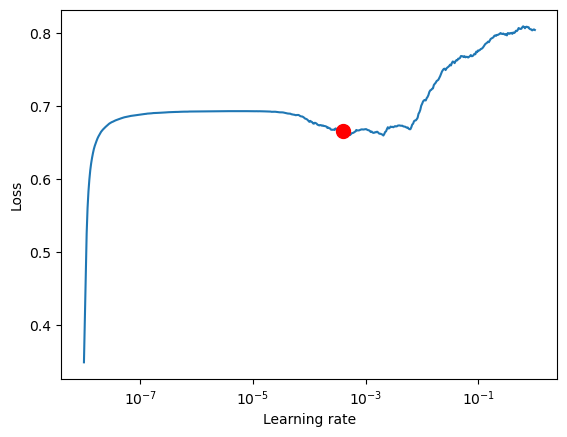

In [19]:
tuner = Tuner(trainer)

# Auto-scale batch size by growing it exponentially (default)
lr_finder = tuner.lr_find(model, mode="exponential", datamodule=dm, num_training=500)
fig = lr_finder.plot(suggest=True)
fig.show()


## Run training

In [20]:
trainer.fit(model, datamodule=dm)

Dataset already exists, skipping download and extraction...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | conv_1 | Sequential | 448   
1 | conv_2 | Sequential | 4.6 K 
2 | conv_3 | Sequential | 18.5 K
3 | fc_1   | Sequential | 11.1 M
4 | fc_2   | Sequential | 258   
--------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.530    Total estimated model params size (MB)


Dataset created, split:
training images: 19999
validation images: 4999


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Tensorboard logs
We can use tensorboard to visualize our training metrics.

We can either manually start the tensorboard server and go to [localhost:6006](http://localhost:6006)

In [1]:
!tensorboard --logdir='./lightning_logs' --bind_all

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.13.0 at http://27b367440664:6006/ (Press CTRL+C to quit)
^C


The other possibility is to use the tensorboard extension directly in the notebook:

In [2]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs --bind_all